[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LHCfitNikhef/EELSfitter/blob/documentation/tutorials/tutorial_eelsfitter.ipynb)

# EELSFitter tutorial

In this tutorial, we are going to train a model of the zero-loss peak (ZLP) background of polytopic WS$_2$ nanoflowers. Individiual spectra are first classified as a function of the local thickness with $K$-means clustering before serving as input to a feedforward neural network. 

The ZLP models can be used to obtain a ZLP-subtracted spectral image (SI), which in turn gives access to the dielectric function through the Kramers-Krönig analysis. One can also find the bandgap energy from the subtracted spectrum.

## Loading the SI

First of all, let us import the EELSFitter package:

In [1]:
import os
import numpy as np

import EELSFitter as ef
from EELSFitter.core.spectral_image import SpectralImage as spectim
from EELSFitter.plotting.zlp import plot_zlp_signal
from EELSFitter.plotting.heatmaps import plot_heatmap

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size': 12})
rc('text', usetex=True)

Next, we load the spectral image and specify the location where we would like to store our output, such as plots.

In [2]:
dm4_path = "/Users/jaco/Documents/CBL-ML/EELS_KK/dmfiles/area03-eels-SI-aligned.dm4"
im = spectim.load_data(dm4_path)
im.output_path = "/Users/jaco/Documents/CBL-ML/EELS_KK/examples/output/" #TODO create automatically if it does not exist

The below specifies some of our plot settings:

In [3]:
cmap="coolwarm"
npix_xtick=26.25
npix_ytick=26.25
sig_ticks = 3
scale_ticks = 1E-3
tick_int = True

cb_scale=0.85
title_specimen = r'$\rm{WS_2\;nanoflower\;}$'
save_title_specimen = 'WS2_nanoflower_flake'
save_loc = im.output_path

im.e0       = 200                           # keV
im.beta     = 67.2                          # mrad

## Visualising the SI

With the spectral image loaded, we can take a first look at what our image actually looks like. We decide to produce a heatmap of the integrated intensity, which is a measure of the local thickness.

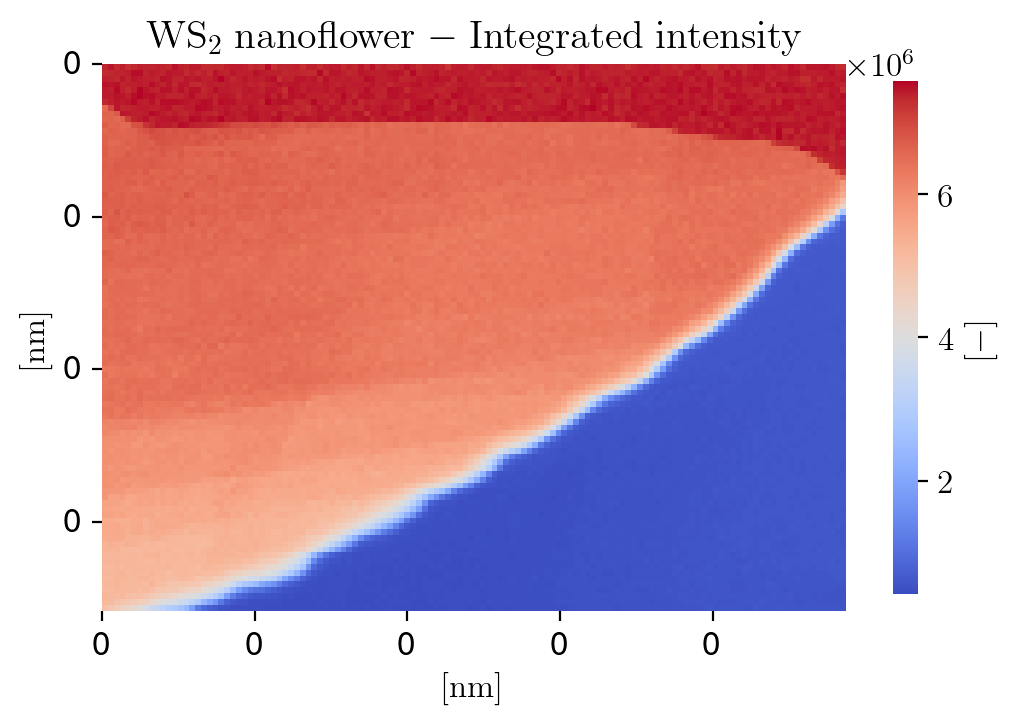

In [4]:
im.calc_axes()
intensity = np.sum(im.data, axis=2)
save_as = os.path.join(save_loc, "integrated_intensity.pdf")
fig = plot_heatmap(im, intensity, title = title_specimen + r'$\rm{-\;Integrated\;intensity\;}$',
                cbar_kws={'label': r'$\rm{[-]\;}$','shrink':cb_scale}, discrete_colormap = False,
                xlab = r'$\rm{[nm]\;}$', ylab = r'$\rm{[nm]\;}$', cmap = cmap,
                sig_ticks = sig_ticks, scale_ticks=scale_ticks, npix_xtick = npix_xtick, npix_ytick = npix_ytick, tick_int = tick_int,
                save_as = save_as)

## Clustering

Since the ZLP intensity depends strongly on the local thickness of the specimen, first of all we group individual spectra as a function of their thickness by means of unsupervised machine learning, specifically by means of the K-means clustering algorithm: 

In [5]:
n_clusters = 5
im.cluster(n_clusters)
im.set_n(4.1462, n_background = 1)   

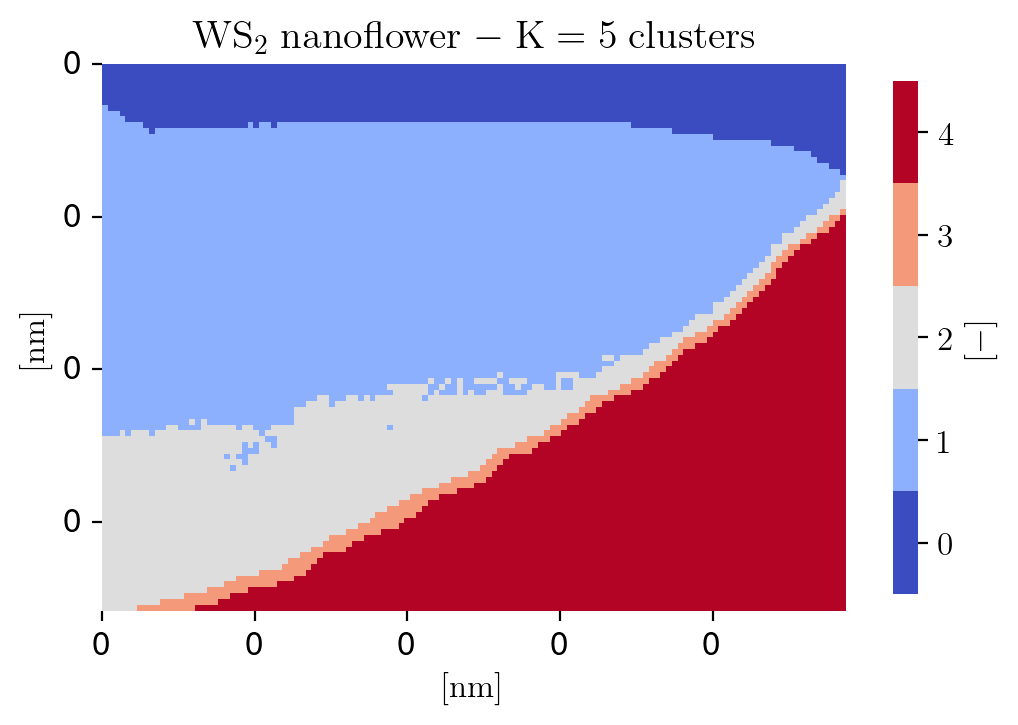

In [6]:
fig = plot_heatmap(im, im.clustered, title = title_specimen +  r'$\rm{-\;K=%d\;clusters\;}$' % n_clusters,
                cbar_kws={'label': r'$\rm{[-]\;}$','shrink':cb_scale}, discrete_colormap = True,
                xlab = r'$\rm{[nm]\;}$', ylab = r'$\rm{[nm]\;}$', cmap = cmap,
                sig_ticks = sig_ticks, scale_ticks = scale_ticks, npix_xtick = npix_xtick, npix_ytick = npix_ytick, tick_int = tick_int,
                save_as = save_loc + save_title_specimen + '_Clustered')

## Training of the ZLP

The ZLP can be trained with the following lines of code. It produces a couple of plots:
1.  The raw signal per cluster, including the position of the hyperparamter $E_I$
2.  The slow of the raw signal per cluster
3.  The value of the loss per epoch on both training and validation set

The more replicas one uses to train the ZLP, the more accurate the model becomes.

Plotting choice of dE1...
Plots stored in /Users/jaco/Documents/CBL-ML/EELS_KK/examples/output/
dE1 & dE2: [2.4   2.15  2.075 1.75  1.3  ] [7.20000011 6.4500001  6.22500009 5.25000008 3.90000006]
Started training on replica number 0, at time  2021-09-29 21:45:31.454260
Rep 0, Epoch 200, Training loss 1248.439, Testing loss 1464.848
Rep 0, Epoch 400, Training loss 452.518, Testing loss 525.759
Rep 0, Epoch 600, Training loss 197.737, Testing loss 211.13
Rep 0, Epoch 800, Training loss 189.393, Testing loss 196.259
Rep 0, Epoch 1000, Training loss 189.082, Testing loss 195.56


<Figure size 720x648 with 0 Axes>

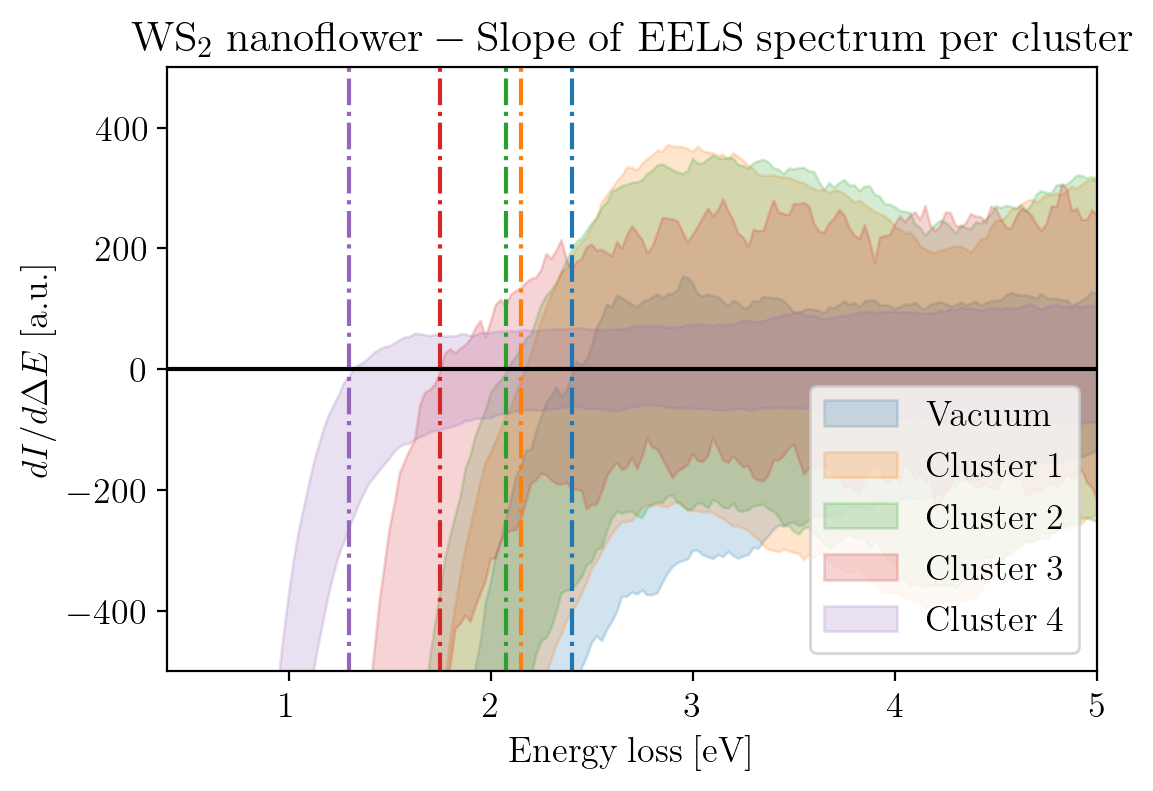

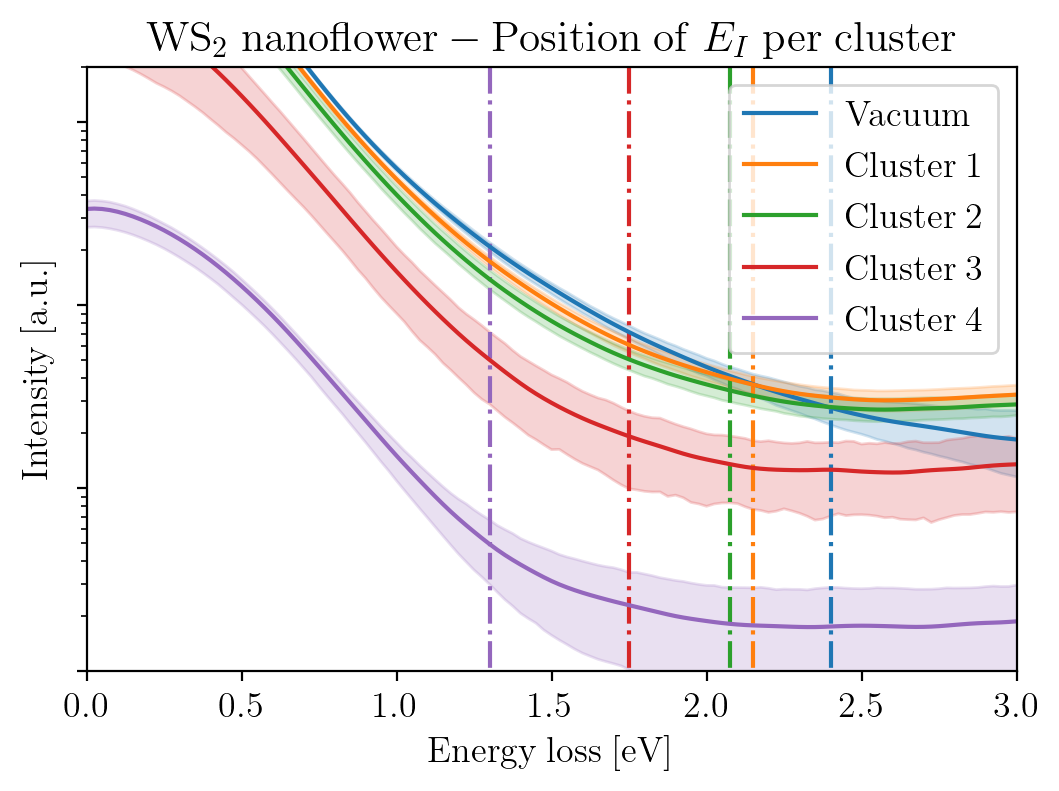

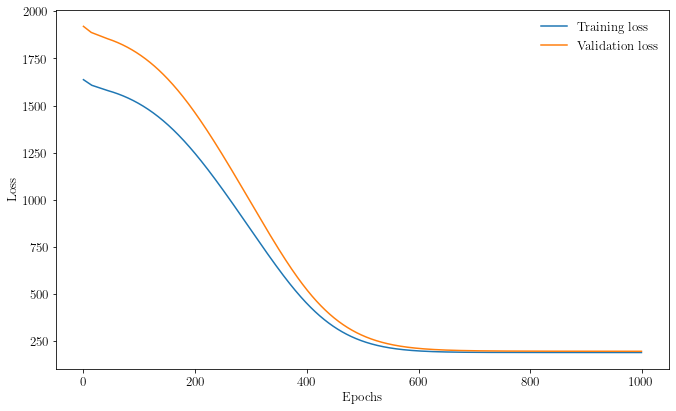

In [7]:
n_rep = 1  # number of replicas
n_epochs = 1000  # number of epochs
display_step = 200 # show training report after display_step steps
path_to_models = os.path.join(os.getcwd(), "models/tutorial") # where to store the trained models

if not os.path.exists(path_to_models):
    os.mkdir(path_to_models)

im.train_zlp(n_clusters=n_clusters,
            n_rep=n_rep,
            bs_rep_num=1,
            path_to_models=path_to_models,
            display_step=display_step,
            n_epochs=n_epochs,
            plot_de1=True,
            prob=True,
            perc_de1=16)

Since the actual training time that is needed to obtain a fair ammount of models (~5000) takes a couple of hourse, we provide a set of *pretrained* models to experiment with. We will use these in what follows. 

They can be downloaded by

In [8]:
import wget
url = 'https://github.com/LHCfitNikhef/EELSfitter/blob/documentation/Models/tutorial/models_E1_p16_k5.zip?raw=true'
wget.download(url)

 22% [................                                                        ]  2785280 / 12455474

 57% [.........................................                               ]  7135232 / 12455474

 88% [...............................................................         ] 10960896 / 12455474

100% [........................................................................] 12455474 / 12455474

'models_E1_p16_k5.zip'

In [9]:
!unzip models_E1_p16_k5.zip

Archive:  models_E1_p16_k5.zip
   creating: models_E1_p16_k5/
  inflating: models_E1_p16_k5/costs_train_244.txt  
  inflating: models_E1_p16_k5/nn_rep_2501  
  inflating: models_E1_p16_k5/nn_rep_1384  
  inflating: models_E1_p16_k5/nn_rep_768  
  inflating: models_E1_p16_k5/costs_train_522.txt  
  inflating: models_E1_p16_k5/nn_rep_2733  
  inflating: models_E1_p16_k5/costs_train_536.txt  
  inflating: models_E1_p16_k5/nn_rep_3285  
  inflating: models_E1_p16_k5/nn_rep_2357  
  inflating: models_E1_p16_k5/nn_rep_2959  
  inflating: models_E1_p16_k5/nn_rep_2165  
  inflating: models_E1_p16_k5/costs_train_250.txt  
  inflating: models_E1_p16_k5/nn_rep_902  
  inflating: models_E1_p16_k5/nn_rep_4292  
  inflating: models_E1_p16_k5/nn_rep_1526  
  inflating: models_E1_p16_k5/nn_rep_4868  
  inflating: models_E1_p16_k5/nn_rep_4054  
  inflating: models_E1_p16_k5/costs_train_278.txt  
  inflating: models_E1_p16_k5/nn_rep_3271  
  inflating: models_E1_p16_k5/costs_test_833.txt  
  inflating: 

  inflating: models_E1_p16_k5/nn_rep_4835  
  inflating: models_E1_p16_k5/nn_rep_197  
  inflating: models_E1_p16_k5/nn_rep_1749  
  inflating: models_E1_p16_k5/nn_rep_3822  
  inflating: models_E1_p16_k5/nn_rep_3648  
  inflating: models_E1_p16_k5/costs_test_761.txt  
  inflating: models_E1_p16_k5/costs_train_494.txt  
  inflating: models_E1_p16_k5/nn_rep_1923  
  inflating: models_E1_p16_k5/nn_rep_2107  
  inflating: models_E1_p16_k5/costs_test_952.txt  
  inflating: models_E1_p16_k5/nn_rep_960  
  inflating: models_E1_p16_k5/nn_rep_1782  
  inflating: models_E1_p16_k5/nn_rep_2335  
  inflating: models_E1_p16_k5/costs_train_319.txt  
  inflating: models_E1_p16_k5/nn_rep_3683  
  inflating: models_E1_p16_k5/nn_rep_2751  
  inflating: models_E1_p16_k5/nn_rep_2563  
  inflating: models_E1_p16_k5/costs_test_946.txt  
  inflating: models_E1_p16_k5/nn_rep_538  
  inflating: models_E1_p16_k5/nn_rep_4694  
  inflating: models_E1_p16_k5/nn_rep_4452  
  inflating: models_E1_p16_k5/nn_rep_1120 

  inflating: models_E1_p16_k5/costs_train_910.txt  
  inflating: models_E1_p16_k5/nn_rep_3428  
  inflating: models_E1_p16_k5/nn_rep_3870  
  inflating: models_E1_p16_k5/nn_rep_4269  
  inflating: models_E1_p16_k5/costs_train_904.txt  
  inflating: models_E1_p16_k5/nn_rep_4867  
  inflating: models_E1_p16_k5/costs_test_429.txt  
  inflating: models_E1_p16_k5/nn_rep_1529  
  inflating: models_E1_p16_k5/nn_rep_3283  
  inflating: models_E1_p16_k5/nn_rep_2351  
  inflating: models_E1_p16_k5/costs_train_643.txt  
  inflating: models_E1_p16_k5/nn_rep_2163  
  inflating: models_E1_p16_k5/costs_train_125.txt  
  inflating: models_E1_p16_k5/nn_rep_4294  
  inflating: models_E1_p16_k5/nn_rep_138  
  inflating: models_E1_p16_k5/nn_rep_904  
  inflating: models_E1_p16_k5/nn_rep_2507  
  inflating: models_E1_p16_k5/costs_train_131.txt  
  inflating: models_E1_p16_k5/nn_rep_1382  
  inflating: models_E1_p16_k5/costs_train_657.txt  
  inflating: models_E1_p16_k5/nn_rep_2735  
  inflating: models_E1_

  inflating: models_E1_p16_k5/nn_rep_3444  
  inflating: models_E1_p16_k5/nn_rep_2596  
  inflating: models_E1_p16_k5/nn_rep_1313  
  inflating: models_E1_p16_k5/costs_test_831.txt  
  inflating: models_E1_p16_k5/nn_rep_4661  
  inflating: models_E1_p16_k5/nn_rep_1121  
  inflating: models_E1_p16_k5/nn_rep_4453  
  inflating: models_E1_p16_k5/nn_rep_3676  
  inflating: models_E1_p16_k5/nn_rep_1545  
  inflating: models_E1_p16_k5/nn_rep_4037  
  inflating: models_E1_p16_k5/nn_rep_3212  
  inflating: models_E1_p16_k5/costs_train_508.txt  
  inflating: models_E1_p16_k5/costs_test_825.txt  
  inflating: models_E1_p16_k5/nn_rep_3020  
  inflating: models_E1_p16_k5/nn_rep_995  
  inflating: models_E1_p16_k5/nn_rep_1777  
  inflating: models_E1_p16_k5/nn_rep_4205  
  inflating: models_E1_p16_k5/costs_train_520.txt  
  inflating: models_E1_p16_k5/nn_rep_2334  
  inflating: models_E1_p16_k5/nn_rep_2106  
  inflating: models_E1_p16_k5/nn_rep_961  
  inflating: models_E1_p16_k5/nn_rep_1783  
  in

  inflating: models_E1_p16_k5/nn_rep_4771  
  inflating: models_E1_p16_k5/costs_test_798.txt  
  inflating: models_E1_p16_k5/costs_test_954.txt  
  inflating: models_E1_p16_k5/nn_rep_3130  
  inflating: models_E1_p16_k5/costs_train_479.txt  
  inflating: models_E1_p16_k5/nn_rep_1667  
  inflating: models_E1_p16_k5/nn_rep_885  
  inflating: models_E1_p16_k5/nn_rep_4315  
  inflating: models_E1_p16_k5/nn_rep_1455  
  inflating: models_E1_p16_k5/nn_rep_4127  
  inflating: models_E1_p16_k5/nn_rep_3302  
  inflating: models_E1_p16_k5/costs_train_848.txt  
  inflating: models_E1_p16_k5/costs_test_565.txt  
  inflating: models_E1_p16_k5/costs_train_690.txt  
  inflating: models_E1_p16_k5/nn_rep_1009  
  inflating: models_E1_p16_k5/nn_rep_1835  
  inflating: models_E1_p16_k5/nn_rep_4749  
  inflating: models_E1_p16_k5/costs_test_203.txt  
  inflating: models_E1_p16_k5/costs_test_217.txt  
  inflating: models_E1_p16_k5/nn_rep_3934  
  inflating: models_E1_p16_k5/nn_rep_3108  
  inflating: model

  inflating: models_E1_p16_k5/nn_rep_4143  
  inflating: models_E1_p16_k5/nn_rep_3366  
  inflating: models_E1_p16_k5/costs_train_645.txt  
  inflating: models_E1_p16_k5/costs_train_123.txt  
  inflating: models_E1_p16_k5/nn_rep_3968  
  inflating: models_E1_p16_k5/nn_rep_2086  
  inflating: models_E1_p16_k5/nn_rep_3154  
  inflating: models_E1_p16_k5/nn_rep_1603  
  inflating: models_E1_p16_k5/nn_rep_4371  
  inflating: models_E1_p16_k5/nn_rep_640  
  inflating: models_E1_p16_k5/nn_rep_472  
  inflating: models_E1_p16_k5/costs_train_876.txt  
  inflating: models_E1_p16_k5/nn_rep_2429  
  inflating: models_E1_p16_k5/nn_rep_2871  
  inflating: models_E1_p16_k5/costs_train_862.txt  
  inflating: models_E1_p16_k5/costs_test_229.txt  
  inflating: models_E1_p16_k5/nn_rep_224  
  inflating: models_E1_p16_k5/nn_rep_4188  
  inflating: models_E1_p16_k5/costs_test_201.txt  
  inflating: models_E1_p16_k5/nn_rep_2885  
  inflating: models_E1_p16_k5/nn_rep_3957  
  inflating: models_E1_p16_k5/nn_

  inflating: models_E1_p16_k5/nn_rep_4594  
  inflating: models_E1_p16_k5/nn_rep_638  
  inflating: models_E1_p16_k5/costs_test_850.txt  
  inflating: models_E1_p16_k5/nn_rep_2663  
  inflating: models_E1_p16_k5/costs_test_688.txt  
  inflating: models_E1_p16_k5/nn_rep_3583  
  inflating: models_E1_p16_k5/nn_rep_2451  
  inflating: models_E1_p16_k5/nn_rep_2035  
  inflating: models_E1_p16_k5/nn_rep_2809  
  inflating: models_E1_p16_k5/nn_rep_852  
  inflating: models_E1_p16_k5/costs_test_844.txt  
  inflating: models_E1_p16_k5/costs_train_569.txt  
  inflating: models_E1_p16_k5/nn_rep_1482  
  inflating: models_E1_p16_k5/nn_rep_2207  
  inflating: models_E1_p16_k5/costs_test_677.txt  
  inflating: models_E1_p16_k5/nn_rep_3548  
  inflating: models_E1_p16_k5/costs_train_582.txt  
  inflating: models_E1_p16_k5/costs_test_46.txt  
  inflating: models_E1_p16_k5/costs_test_111.txt  
  inflating: models_E1_p16_k5/nn_rep_1811  
  inflating: models_E1_p16_k5/nn_rep_12  
  inflating: models_E1_

  inflating: models_E1_p16_k5/nn_rep_4954  
  inflating: models_E1_p16_k5/costs_test_460.txt  
  inflating: models_E1_p16_k5/costs_train_82.txt  
  inflating: models_E1_p16_k5/costs_train_795.txt  
  inflating: models_E1_p16_k5/nn_rep_4168  
  inflating: models_E1_p16_k5/nn_rep_41  
  inflating: models_E1_p16_k5/nn_rep_2891  
  inflating: models_E1_p16_k5/nn_rep_3943  
  inflating: models_E1_p16_k5/nn_rep_1628  
  inflating: models_E1_p16_k5/costs_test_306.txt  
  inflating: models_E1_p16_k5/costs_test_312.txt  
  inflating: models_E1_p16_k5/nn_rep_492  
  inflating: models_E1_p16_k5/nn_rep_1842  
  inflating: models_E1_p16_k5/costs_test_474.txt  
  inflating: models_E1_p16_k5/costs_train_96.txt  
  inflating: models_E1_p16_k5/costs_train_781.txt  
  inflating: models_E1_p16_k5/nn_rep_3729  
  inflating: models_E1_p16_k5/costs_train_959.txt  
  inflating: models_E1_p16_k5/nn_rep_801  
  inflating: models_E1_p16_k5/nn_rep_4391  
  inflating: models_E1_p16_k5/nn_rep_3988  
  inflating: m

  inflating: models_E1_p16_k5/costs_test_927.txt  
  inflating: models_E1_p16_k5/costs_test_714.txt  
  inflating: models_E1_p16_k5/nn_rep_2837  
  inflating: models_E1_p16_k5/nn_rep_2239  
  inflating: models_E1_p16_k5/costs_train_387.txt  
  inflating: models_E1_p16_k5/nn_rep_262  
  inflating: models_E1_p16_k5/costs_train_393.txt  
  inflating: models_E1_p16_k5/nn_rep_606  
  inflating: models_E1_p16_k5/nn_rep_434  
  inflating: models_E1_p16_k5/nn_rep_4798  
  inflating: models_E1_p16_k5/costs_test_700.txt  
  inflating: models_E1_p16_k5/nn_rep_1810  
  inflating: models_E1_p16_k5/costs_test_728.txt  
  inflating: models_E1_p16_k5/nn_rep_3549  
  inflating: models_E1_p16_k5/nn_rep_898  
  inflating: models_E1_p16_k5/nn_rep_4308  
  inflating: models_E1_p16_k5/nn_rep_3911  
  inflating: models_E1_p16_k5/nn_rep_13  
  inflating: models_E1_p16_k5/nn_rep_4906  
  inflating: models_E1_p16_k5/nn_rep_1448  
  inflating: models_E1_p16_k5/nn_rep_296  
  inflating: models_E1_p16_k5/nn_rep_23

  inflating: models_E1_p16_k5/nn_rep_4688  
  inflating: models_E1_p16_k5/costs_train_584.txt  
  inflating: models_E1_p16_k5/costs_test_671.txt  
  inflating: models_E1_p16_k5/costs_test_40.txt  
  inflating: models_E1_p16_k5/costs_test_117.txt  
  inflating: models_E1_p16_k5/nn_rep_716  
  inflating: models_E1_p16_k5/nn_rep_1594  
  inflating: models_E1_p16_k5/costs_test_498.txt  
  inflating: models_E1_p16_k5/nn_rep_2311  
  inflating: models_E1_p16_k5/nn_rep_2123  
  inflating: models_E1_p16_k5/nn_rep_944  
  inflating: models_E1_p16_k5/nn_rep_178  
  inflating: models_E1_p16_k5/nn_rep_2547  
  inflating: models_E1_p16_k5/nn_rep_3495  
  inflating: models_E1_p16_k5/costs_train_779.txt  
  inflating: models_E1_p16_k5/nn_rep_4482  
  inflating: models_E1_p16_k5/nn_rep_2775  
  inflating: models_E1_p16_k5/costs_train_46.txt  
  inflating: models_E1_p16_k5/costs_train_751.txt  
  inflating: models_E1_p16_k5/costs_train_989.txt  
  inflating: models_E1_p16_k5/nn_rep_3461  
  inflating: 

  inflating: models_E1_p16_k5/nn_rep_1953  
  inflating: models_E1_p16_k5/nn_rep_3638  
  inflating: models_E1_p16_k5/nn_rep_4280  
  inflating: models_E1_p16_k5/nn_rep_910  
  inflating: models_E1_p16_k5/nn_rep_2177  
  inflating: models_E1_p16_k5/nn_rep_3899  
  inflating: models_E1_p16_k5/nn_rep_3297  
  inflating: models_E1_p16_k5/nn_rep_2345  
  inflating: models_E1_p16_k5/costs_train_744.txt  
  inflating: models_E1_p16_k5/costs_train_53.txt  
  inflating: models_E1_p16_k5/nn_rep_2721  
  inflating: models_E1_p16_k5/costs_train_988.txt  
  inflating: models_E1_p16_k5/nn_rep_1998  
  inflating: models_E1_p16_k5/costs_train_750.txt  
  inflating: models_E1_p16_k5/costs_train_47.txt  
  inflating: models_E1_p16_k5/nn_rep_548  
  inflating: models_E1_p16_k5/nn_rep_1396  
  inflating: models_E1_p16_k5/nn_rep_2513  
  inflating: models_E1_p16_k5/nn_rep_3607  
  inflating: models_E1_p16_k5/nn_rep_4422  
  inflating: models_E1_p16_k5/nn_rep_1150  
  inflating: models_E1_p16_k5/nn_rep_461

  inflating: models_E1_p16_k5/nn_rep_525  
  inflating: models_E1_p16_k5/nn_rep_4689  
  inflating: models_E1_p16_k5/costs_train_395.txt  
  inflating: models_E1_p16_k5/nn_rep_1901  
  inflating: models_E1_p16_k5/nn_rep_3458  
  inflating: models_E1_p16_k5/costs_test_706.txt  
  inflating: models_E1_p16_k5/nn_rep_4219  
  inflating: models_E1_p16_k5/costs_test_712.txt  
  inflating: models_E1_p16_k5/nn_rep_989  
  inflating: models_E1_p16_k5/nn_rep_3800  
  inflating: models_E1_p16_k5/nn_rep_387  
  inflating: models_E1_p16_k5/costs_train_381.txt  
  inflating: models_E1_p16_k5/nn_rep_1559  
  inflating: models_E1_p16_k5/nn_rep_4817  
  inflating: models_E1_p16_k5/nn_rep_327  
  inflating: models_E1_p16_k5/costs_test_713.txt  
  inflating: models_E1_p16_k5/nn_rep_2972  
  inflating: models_E1_p16_k5/costs_train_380.txt  
  inflating: models_E1_p16_k5/nn_rep_929  
  inflating: models_E1_p16_k5/nn_rep_115  
  inflating: models_E1_p16_k5/nn_rep_571  
  inflating: models_E1_p16_k5/costs_tr

  inflating: models_E1_p16_k5/costs_train_61.txt  
  inflating: models_E1_p16_k5/costs_test_483.txt  
  inflating: models_E1_p16_k5/nn_rep_2907  
  inflating: models_E1_p16_k5/nn_rep_2309  
  inflating: models_E1_p16_k5/nn_rep_352  
  inflating: models_E1_p16_k5/nn_rep_4238  
  inflating: models_E1_p16_k5/nn_rep_194  
  inflating: models_E1_p16_k5/nn_rep_3821  
  inflating: models_E1_p16_k5/costs_train_49.txt  
  inflating: models_E1_p16_k5/nn_rep_1578  
  inflating: models_E1_p16_k5/nn_rep_4836  
  inflating: models_E1_p16_k5/costs_train_986.txt  
  inflating: models_E1_p16_k5/nn_rep_2799  
  inflating: models_E1_p16_k5/costs_train_992.txt  
  inflating: models_E1_p16_k5/nn_rep_1920  
  inflating: models_E1_p16_k5/nn_rep_3479  
  inflating: models_E1_p16_k5/costs_test_332.txt  
  inflating: models_E1_p16_k5/nn_rep_2336  
  inflating: models_E1_p16_k5/nn_rep_2104  
  inflating: models_E1_p16_k5/nn_rep_2938  
  inflating: models_E1_p16_k5/costs_train_979.txt  
  inflating: models_E1_p16

  inflating: models_E1_p16_k5/costs_train_987.txt  
  inflating: models_E1_p16_k5/nn_rep_3881  
  inflating: models_E1_p16_k5/nn_rep_2953  
  inflating: models_E1_p16_k5/costs_train_48.txt  
  inflating: models_E1_p16_k5/nn_rep_908  
  inflating: models_E1_p16_k5/nn_rep_4298  
  inflating: models_E1_p16_k5/nn_rep_134  
  inflating: models_E1_p16_k5/nn_rep_4862  
  inflating: models_E1_p16_k5/costs_test_482.txt  
  inflating: models_E1_p16_k5/costs_train_60.txt  
  inflating: models_E1_p16_k5/costs_train_777.txt  
  inflating: models_E1_p16_k5/nn_rep_3875  
  inflating: models_E1_p16_k5/nn_rep_3049  
  inflating: models_E1_p16_k5/nn_rep_4608  
  inflating: models_E1_p16_k5/nn_rep_1148  
  inflating: models_E1_p16_k5/nn_rep_796  
  inflating: models_E1_p16_k5/nn_rep_1974  
  inflating: models_E1_p16_k5/costs_test_496.txt  
  inflating: models_E1_p16_k5/costs_train_74.txt  
  inflating: models_E1_p16_k5/costs_train_763.txt  
  inflating: models_E1_p16_k5/costs_test_119.txt  
  inflating: 

  inflating: models_E1_p16_k5/nn_rep_4093  
  inflating: models_E1_p16_k5/nn_rep_4255  
  inflating: models_E1_p16_k5/nn_rep_1727  
  inflating: models_E1_p16_k5/nn_rep_3070  
  inflating: models_E1_p16_k5/nn_rep_3242  
  inflating: models_E1_p16_k5/nn_rep_2390  
  inflating: models_E1_p16_k5/costs_test_720.txt  
  inflating: models_E1_p16_k5/nn_rep_4067  
  inflating: models_E1_p16_k5/nn_rep_1515  
  inflating: models_E1_p16_k5/costs_test_734.txt  
  inflating: models_E1_p16_k5/nn_rep_3626  
  inflating: models_E1_p16_k5/nn_rep_4403  
  inflating: models_E1_p16_k5/nn_rep_1171  
  inflating: models_E1_p16_k5/nn_rep_4631  
  inflating: models_E1_p16_k5/nn_rep_1343  
  inflating: models_E1_p16_k5/nn_rep_3414  
  inflating: models_E1_p16_k5/nn_rep_300  
  inflating: models_E1_p16_k5/nn_rep_4890  
  inflating: models_E1_p16_k5/nn_rep_3289  
  inflating: models_E1_p16_k5/nn_rep_2169  
  inflating: models_E1_p16_k5/nn_rep_3887  
  inflating: models_E1_p16_k5/nn_rep_2955  
  inflating: models

  inflating: models_E1_p16_k5/nn_rep_872  
  inflating: models_E1_p16_k5/nn_rep_1690  
  inflating: models_E1_p16_k5/nn_rep_2471  
  inflating: models_E1_p16_k5/costs_test_308.txt  
  inflating: models_E1_p16_k5/nn_rep_4786  
  inflating: models_E1_p16_k5/costs_train_943.txt  
  inflating: models_E1_p16_k5/nn_rep_618  
  inflating: models_E1_p16_k5/nn_rep_3791  
  inflating: models_E1_p16_k5/nn_rep_2643  
  inflating: models_E1_p16_k5/costs_test_446.txt  
  inflating: models_E1_p16_k5/nn_rep_3557  
  inflating: models_E1_p16_k5/nn_rep_2485  
  inflating: models_E1_p16_k5/nn_rep_1200  
  inflating: models_E1_p16_k5/nn_rep_4772  
  inflating: models_E1_p16_k5/nn_rep_1032  
  inflating: models_E1_p16_k5/nn_rep_4540  
  inflating: models_E1_p16_k5/costs_test_320.txt  
  inflating: models_E1_p16_k5/nn_rep_3765  
  inflating: models_E1_p16_k5/nn_rep_4918  
  inflating: models_E1_p16_k5/nn_rep_1456  
  inflating: models_E1_p16_k5/costs_test_334.txt  
  inflating: models_E1_p16_k5/nn_rep_288  

  inflating: models_E1_p16_k5/nn_rep_3504  
  inflating: models_E1_p16_k5/costs_test_123.txt  
  inflating: models_E1_p16_k5/costs_test_74.txt  
  inflating: models_E1_p16_k5/nn_rep_3736  
  inflating: models_E1_p16_k5/costs_test_645.txt  
  inflating: models_E1_p16_k5/nn_rep_4513  
  inflating: models_E1_p16_k5/nn_rep_1061  
  inflating: models_E1_p16_k5/nn_rep_479  
  inflating: models_E1_p16_k5/costs_train_598.txt  
  inflating: models_E1_p16_k5/nn_rep_2422  
  inflating: models_E1_p16_k5/nn_rep_2610  
  inflating: models_E1_p16_k5/nn_rep_1095  
  inflating: models_E1_p16_k5/nn_rep_2274  
  inflating: models_E1_p16_k5/costs_test_48.txt  
  inflating: models_E1_p16_k5/nn_rep_4183  
  inflating: models_E1_p16_k5/nn_rep_821  
  inflating: models_E1_p16_k5/nn_rep_2046  
  inflating: models_E1_p16_k5/nn_rep_3194  
  inflating: models_E1_p16_k5/costs_test_679.txt  
  inflating: models_E1_p16_k5/nn_rep_1862  
  inflating: models_E1_p16_k5/costs_test_692.txt  
  inflating: models_E1_p16_k5/

  inflating: models_E1_p16_k5/nn_rep_2078  
  inflating: models_E1_p16_k5/nn_rep_1299  
  inflating: models_E1_p16_k5/costs_train_376.txt  
  inflating: models_E1_p16_k5/nn_rep_447  
  inflating: models_E1_p16_k5/nn_rep_1897  
  inflating: models_E1_p16_k5/costs_train_410.txt  
  inflating: models_E1_p16_k5/nn_rep_675  
  inflating: models_E1_p16_k5/costs_test_915.txt  
  inflating: models_E1_p16_k5/costs_train_438.txt  
  inflating: models_E1_p16_k5/nn_rep_1863  
  inflating: models_E1_p16_k5/nn_rep_681  
  inflating: models_E1_p16_k5/nn_rep_3708  
  inflating: models_E1_p16_k5/nn_rep_4975  
  inflating: models_E1_p16_k5/nn_rep_4149  
  inflating: models_E1_p16_k5/nn_rep_60  
  inflating: models_E1_p16_k5/nn_rep_3962  
  inflating: models_E1_p16_k5/nn_rep_1609  
  inflating: models_E1_p16_k5/costs_test_901.txt  
  inflating: models_E1_p16_k5/nn_rep_1255  
  inflating: models_E1_p16_k5/costs_test_256.txt  
  inflating: models_E1_p16_k5/nn_rep_4727  
  inflating: models_E1_p16_k5/nn_rep

  inflating: models_E1_p16_k5/nn_rep_659  
  inflating: models_E1_p16_k5/costs_test_379.txt  
  inflating: models_E1_p16_k5/nn_rep_2602  
  inflating: models_E1_p16_k5/costs_train_932.txt  
  inflating: models_E1_p16_k5/nn_rep_2430  
  inflating: models_E1_p16_k5/nn_rep_1248  
  inflating: models_E1_p16_k5/costs_test_580.txt  
  inflating: models_E1_p16_k5/nn_rep_496  
  inflating: models_E1_p16_k5/costs_train_675.txt  
  inflating: models_E1_p16_k5/costs_train_113.txt  
  inflating: models_E1_p16_k5/nn_rep_4508  
  inflating: models_E1_p16_k5/nn_rep_1846  
  inflating: models_E1_p16_k5/nn_rep_4950  
  inflating: models_E1_p16_k5/nn_rep_45  
  inflating: models_E1_p16_k5/costs_train_107.txt  
  inflating: models_E1_p16_k5/nn_rep_3349  
  inflating: models_E1_p16_k5/nn_rep_3947  
  inflating: models_E1_p16_k5/nn_rep_2895  
  inflating: models_E1_p16_k5/costs_test_594.txt  
  inflating: models_E1_p16_k5/costs_train_661.txt  
  inflating: models_E1_p16_k5/costs_train_891.txt  
  inflating

  inflating: models_E1_p16_k5/nn_rep_2038  
  inflating: models_E1_p16_k5/nn_rep_2804  
  inflating: models_E1_p16_k5/nn_rep_407  
  inflating: models_E1_p16_k5/costs_train_258.txt  
  inflating: models_E1_p16_k5/nn_rep_4599  
  inflating: models_E1_p16_k5/nn_rep_635  
  inflating: models_E1_p16_k5/costs_test_813.txt  
  inflating: models_E1_p16_k5/costs_train_516.txt  
  inflating: models_E1_p16_k5/nn_rep_1823  
  inflating: models_E1_p16_k5/nn_rep_3748  
  inflating: models_E1_p16_k5/costs_test_185.txt  
  inflating: models_E1_p16_k5/costs_train_270.txt  
  inflating: models_E1_p16_k5/nn_rep_4109  
  inflating: models_E1_p16_k5/costs_test_191.txt  
  inflating: models_E1_p16_k5/costs_train_264.txt  
  inflating: models_E1_p16_k5/nn_rep_4935  
  inflating: models_E1_p16_k5/nn_rep_20  
  inflating: models_E1_p16_k5/nn_rep_3922  
  inflating: models_E1_p16_k5/costs_test_6.txt  
  inflating: models_E1_p16_k5/costs_train_502.txt  
  inflating: models_E1_p16_k5/nn_rep_1649  
  inflating: m

  inflating: models_E1_p16_k5/nn_rep_4554  
  inflating: models_E1_p16_k5/nn_rep_1214  
  inflating: models_E1_p16_k5/nn_rep_4766  
  inflating: models_E1_p16_k5/nn_rep_3543  
  inflating: models_E1_p16_k5/costs_test_541.txt  
  inflating: models_E1_p16_k5/nn_rep_2491  
  inflating: models_E1_p16_k5/nn_rep_892  
  inflating: models_E1_p16_k5/nn_rep_1670  
  inflating: models_E1_p16_k5/costs_train_878.txt  
  inflating: models_E1_p16_k5/nn_rep_4302  
  inflating: models_E1_p16_k5/costs_test_555.txt  
  inflating: models_E1_p16_k5/nn_rep_3127  
  inflating: models_E1_p16_k5/nn_rep_19  
  inflating: models_E1_p16_k5/nn_rep_3315  
  inflating: models_E1_p16_k5/costs_test_233.txt  
  inflating: models_E1_p16_k5/nn_rep_1442  
  inflating: models_E1_p16_k5/nn_rep_4130  
  inflating: models_E1_p16_k5/nn_rep_3588  
  inflating: models_E1_p16_k5/nn_rep_401  
  inflating: models_E1_p16_k5/nn_rep_633  
  inflating: models_E1_p16_k5/costs_train_893.txt  
  inflating: models_E1_p16_k5/nn_rep_2668  


  inflating: models_E1_p16_k5/nn_rep_4284  
  inflating: models_E1_p16_k5/nn_rep_128  
  inflating: models_E1_p16_k5/costs_test_545.txt  
  inflating: models_E1_p16_k5/nn_rep_914  
  inflating: models_E1_p16_k5/costs_train_868.txt  
  inflating: models_E1_p16_k5/nn_rep_2173  
  inflating: models_E1_p16_k5/nn_rep_2341  
  inflating: models_E1_p16_k5/nn_rep_3293  
  inflating: models_E1_p16_k5/costs_test_223.txt  
  inflating: models_E1_p16_k5/costs_train_459.txt  
  inflating: models_E1_p16_k5/nn_rep_746  
  inflating: models_E1_p16_k5/costs_test_974.txt  
  inflating: models_E1_p16_k5/nn_rep_1198  
  inflating: models_E1_p16_k5/nn_rep_574  
  inflating: models_E1_p16_k5/nn_rep_3099  
  inflating: models_E1_p16_k5/nn_rep_2977  
  inflating: models_E1_p16_k5/nn_rep_110  
  inflating: models_E1_p16_k5/nn_rep_322  
  inflating: models_E1_p16_k5/nn_rep_2379  
  inflating: models_E1_p16_k5/costs_test_960.txt  
  inflating: models_E1_p16_k5/nn_rep_2983  
  inflating: models_E1_p16_k5/nn_rep_3

  inflating: models_E1_p16_k5/nn_rep_1360  
  inflating: models_E1_p16_k5/nn_rep_4612  
  inflating: models_E1_p16_k5/nn_rep_3437  
  inflating: models_E1_p16_k5/costs_test_29.txt  
  inflating: models_E1_p16_k5/nn_rep_1704  
  inflating: models_E1_p16_k5/nn_rep_4276  
  inflating: models_E1_p16_k5/nn_rep_2181  
  inflating: models_E1_p16_k5/nn_rep_3053  
  inflating: models_E1_p16_k5/nn_rep_3261  
  inflating: models_E1_p16_k5/nn_rep_4878  
  inflating: models_E1_p16_k5/nn_rep_1536  
  inflating: models_E1_p16_k5/costs_test_618.txt  
  inflating: models_E1_p16_k5/nn_rep_4044  
  inflating: models_E1_p16_k5/nn_rep_912  
  inflating: models_E1_p16_k5/nn_rep_4282  
  inflating: models_E1_p16_k5/nn_rep_2949  
  inflating: models_E1_p16_k5/costs_test_630.txt  
  inflating: models_E1_p16_k5/nn_rep_2175  
  inflating: models_E1_p16_k5/costs_test_156.txt  
  inflating: models_E1_p16_k5/nn_rep_2347  
  inflating: models_E1_p16_k5/nn_rep_3295  
  inflating: models_E1_p16_k5/nn_rep_2723  
  infl

  inflating: models_E1_p16_k5/nn_rep_1108  
  inflating: models_E1_p16_k5/costs_train_895.txt  
  inflating: models_E1_p16_k5/nn_rep_4487  
  inflating: models_E1_p16_k5/costs_test_427.txt  
  inflating: models_E1_p16_k5/nn_rep_2770  
  inflating: models_E1_p16_k5/nn_rep_3490  
  inflating: models_E1_p16_k5/nn_rep_2542  
  inflating: models_E1_p16_k5/nn_rep_519  
  inflating: models_E1_p16_k5/costs_test_341.txt  
  inflating: models_E1_p16_k5/nn_rep_2126  
  inflating: models_E1_p16_k5/costs_test_355.txt  
  inflating: models_E1_p16_k5/nn_rep_941  
  inflating: models_E1_p16_k5/nn_rep_1591  
  inflating: models_E1_p16_k5/nn_rep_2314  
  inflating: models_E1_p16_k5/costs_test_433.txt  
  inflating: models_E1_p16_k5/nn_rep_3000  
  inflating: models_E1_p16_k5/nn_rep_4225  
  inflating: models_E1_p16_k5/nn_rep_189  
  inflating: models_E1_p16_k5/costs_train_936.txt  
  inflating: models_E1_p16_k5/nn_rep_1757  
  inflating: models_E1_p16_k5/nn_rep_4017  
  inflating: models_E1_p16_k5/nn_re

In [10]:
path_to_pretrained_models = os.path.join(os.getcwd(), "models_E1_p16_k5")

## Training report

The pretaind models have now been downloaded, so let us see what they look like. The cell immediately below loads the models and plots the cost distribution on the training and validation sets.

chi2 plot saved at /Users/jaco/Documents/CBL-ML/EELS_KK/examples/output/


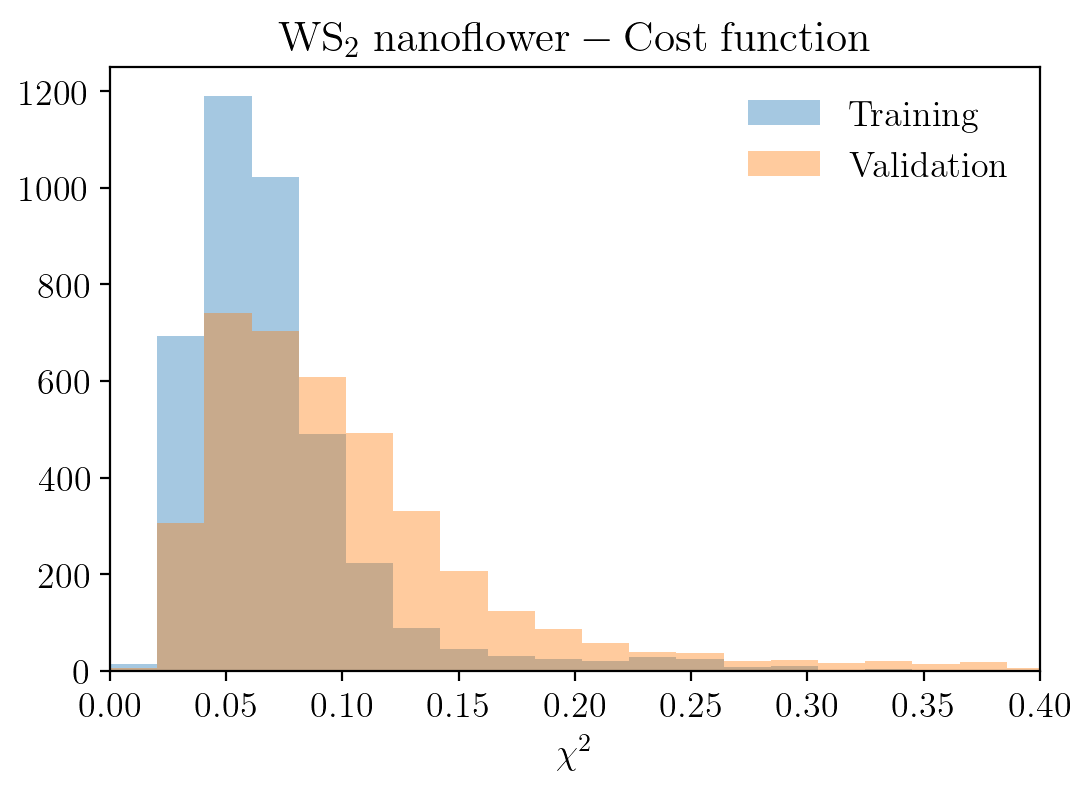

In [11]:
im.load_zlp_models(path_to_models=path_to_pretrained_models, title=r'$\rm{WS_2\;nanoflower-Cost\;function}$')

Besides the distribution of the costs, we can also plot how the predicted ZLPs behave as a function of the total integrated intensity per cluster:

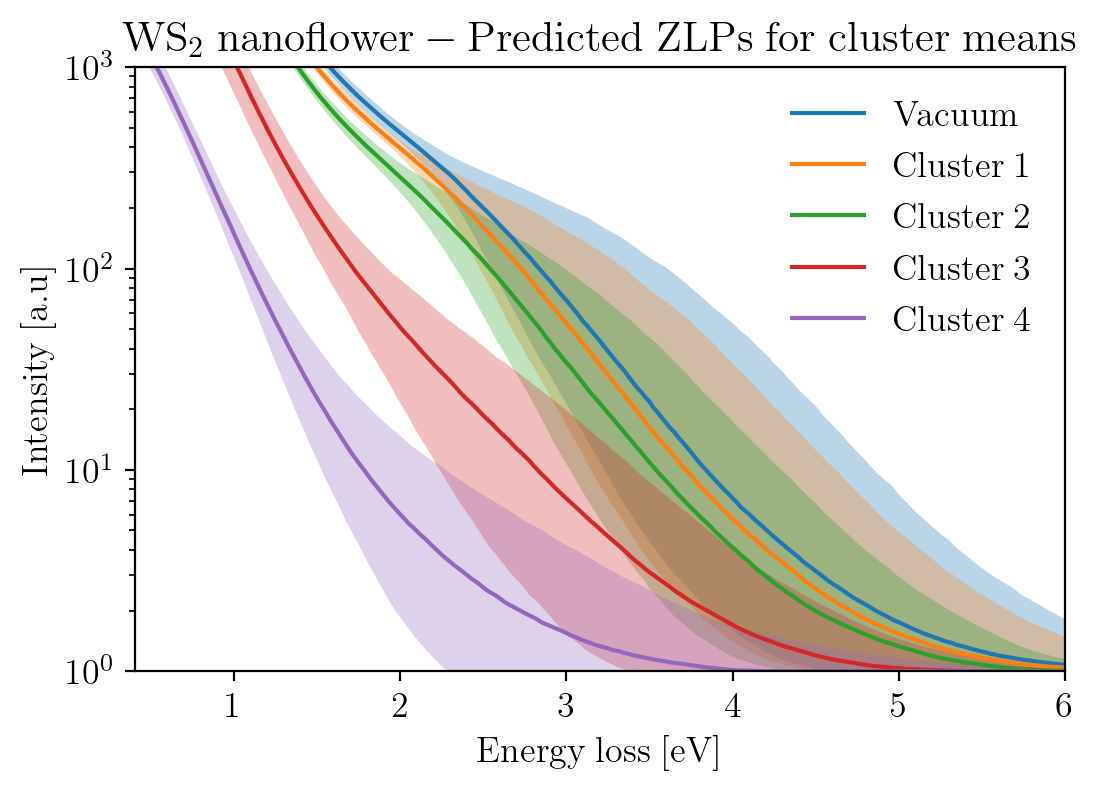

In [12]:
fig = ef.plotting.zlp.plot_zlp_ntot(im)

This shows that the clustering has been effective, since the ZLPs do not overlap before $E_I$. Let us consider a specific pixel, say (30, 90), to see how the subtacted spectrum compares to the raw spectrum.

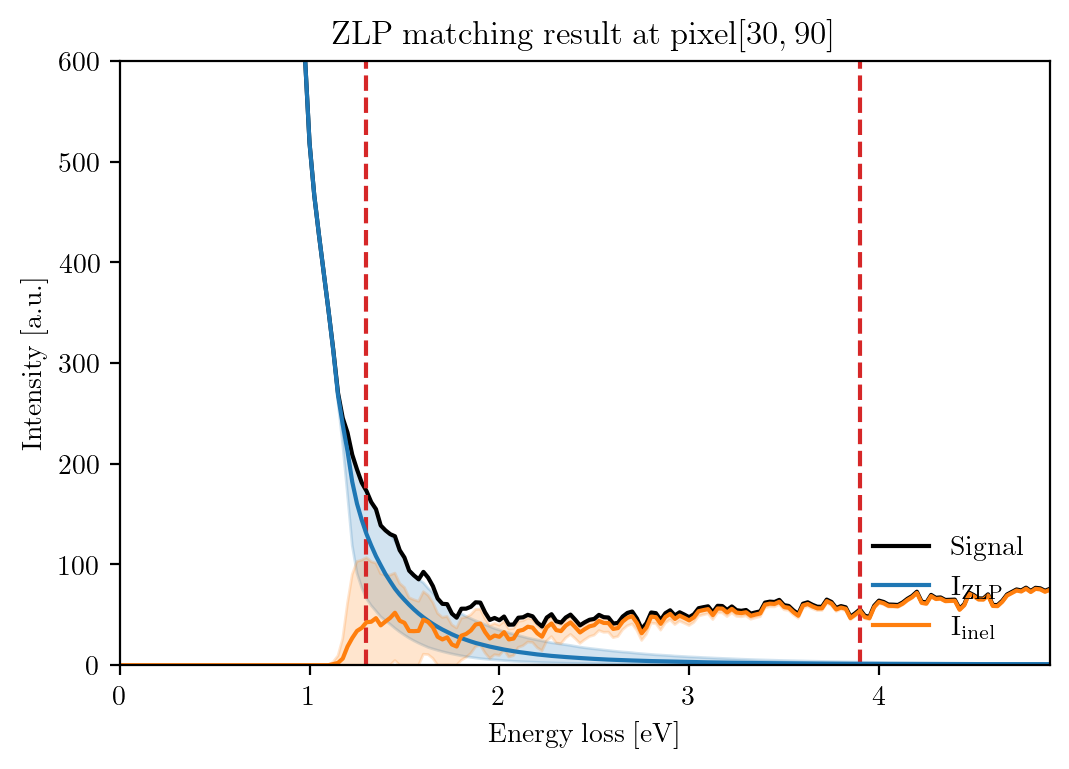

In [13]:
im.pool(5)
fig = ef.plotting.zlp.plot_inel_pred(im, 30, 90)

We conclude this tutorial by plotting, for each cluster, the raw signal plus the ZLP with uncertainties evaluated at the cluster means:

0
1
2
3
4


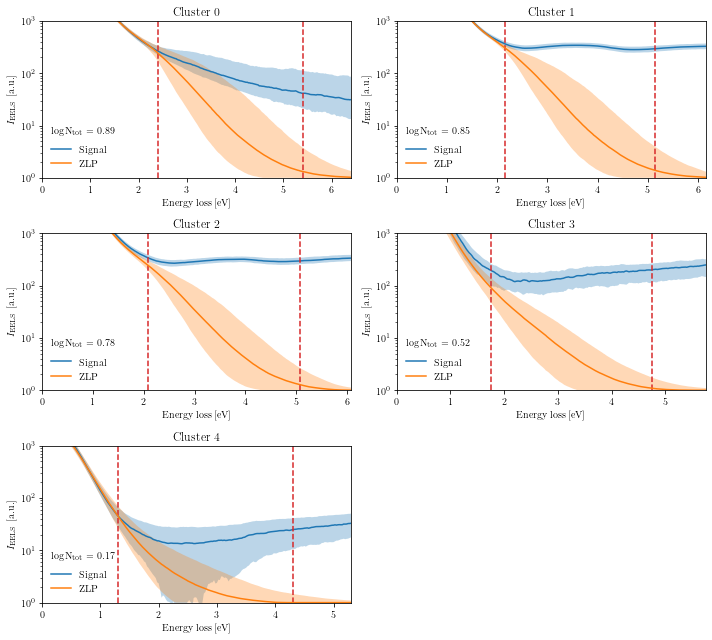

In [14]:
fig = plot_zlp_signal(im)